In [622]:
import os
import re
from pathlib import Path
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [623]:
#origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/sis_selected_timeseries.csv.tar.gz')
csv_file = tf.keras.utils.get_file(
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/device-1.csv.tar.gz')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/utci_selected_timeseries.csv.tar.gz')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-hourly_timeseries.csv.tar.gz')
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-land_timeseries.csv.tar.gz')
csv_file

'/Users/watcharinsarachai/.keras/datasets/era5-land_timeseries.csv.tar.gz'

In [624]:
df = pd.read_csv(csv_file)
row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 32016


,datetime,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
0,2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [625]:
if 'lowAccSis' in df.columns:
    df.pop('lowAccSis')
if 'time' in df.columns:
    df['datetime'] = df['time']
    df.pop('time')
df.head(5)

,datetime,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
0,2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [626]:
# Check what years exist in your dataset
date_col = 'datetime'  # Replace with your actual column name

# Ensure timestamp column is datetime type
if df[date_col].dtype != 'datetime64[ns]':
    df[date_col] = pd.to_datetime(df[date_col])

In [627]:
print(df.shape)
print(df[date_col].min())
print(df[date_col].max())

(32016, 13)
2021-12-31 01:00:00
2025-10-26 00:00:00


In [628]:
# Sort by time if it exists
df.index = df[date_col]
df.pop(date_col)
df = df.sort_index()
print(df.shape)
df.head(5)

(32016, 12)


,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
datetime,,,,,,,,,,,,
2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [629]:
# Try inference first
interval_time = pd.infer_freq(df.index)
print(interval_time)

if interval_time is None:
    delta = df.index.to_series().diff().dropna()
    d = delta.mode().iloc[0] if not delta.mode().empty else delta.median()
    if d % pd.Timedelta(days=1) == pd.Timedelta(0):
        interval_time = 'D'
    elif d % pd.Timedelta(hours=1) == pd.Timedelta(0):
        interval_time = f"{int(d / pd.Timedelta(hours=1))}h"
    elif d % pd.Timedelta(minutes=1) == pd.Timedelta(0):
        interval_time = f"{int(d / pd.Timedelta(minutes=1))}min"
    else:
        interval_time = f"{int(d.total_seconds())}s"
print(interval_time)

None
1h


In [630]:
start_date = df.index.min().floor(interval_time)
end_date = df.index.max().floor(interval_time)
print(start_date)
print(end_date)

2021-12-31 01:00:00
2025-10-26 00:00:00


In [631]:
complete_index = pd.date_range(start=start_date, end=end_date, freq=interval_time)
print(complete_index.shape)
print(complete_index.min())
print(complete_index.max())

# Create a DataFrame with the complete index
df_complete = pd.DataFrame(index=complete_index)
df_complete.head(5)

(33480,)
2021-12-31 01:00:00
2025-10-26 00:00:00


""
2021-12-31 01:00:00
2021-12-31 02:00:00
2021-12-31 03:00:00
2021-12-31 04:00:00
2021-12-31 05:00:00


In [632]:
# Join with original data
df_with_all_times = df_complete.join(df)

print(df.shape)
print(df_with_all_times.shape)

df_with_all_times.head(5)

(32016, 12)
(33576, 12)


,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [633]:
# Print missing data statistics
# Count rows that are entirely NaN
missing_count = df_with_all_times.isna().all(axis=1).sum()
print(f"Found {missing_count} rows with all NA values, out of {len(complete_index)} expected")

# Count columns where all values are NaN
all_na_cols = df_with_all_times.columns[df_with_all_times.isna().all(axis=0)].tolist()
count = len(all_na_cols)
print(f"Found {count} columns with all NA: {all_na_cols}")

Found 1560 rows with all NA values, out of 33480 expected
Found 0 columns with all NA: []


In [634]:
all_zero_count = (df_with_all_times == 0).all(axis=1).sum()
# Or get column names:
all_zero_cols = df.columns[(df_with_all_times == 0).all()].tolist()
print(f"Found {all_zero_count} zero value, out of {len(complete_index)} expected")
print(f"Found {all_zero_cols}")

Found 1104 zero value, out of 33480 expected
Found []


In [635]:
all_cols = [c for c in df_with_all_times.columns]
print(all_cols)

['t2m', 'fal', 'slhf', 'ssr', 'str', 'sshf', 'ssrd', 'strd', 'u10', 'v10', 'sp', 'tp']


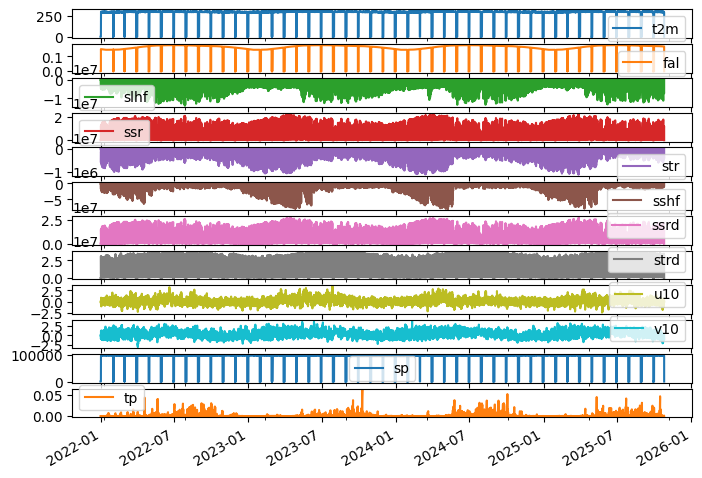

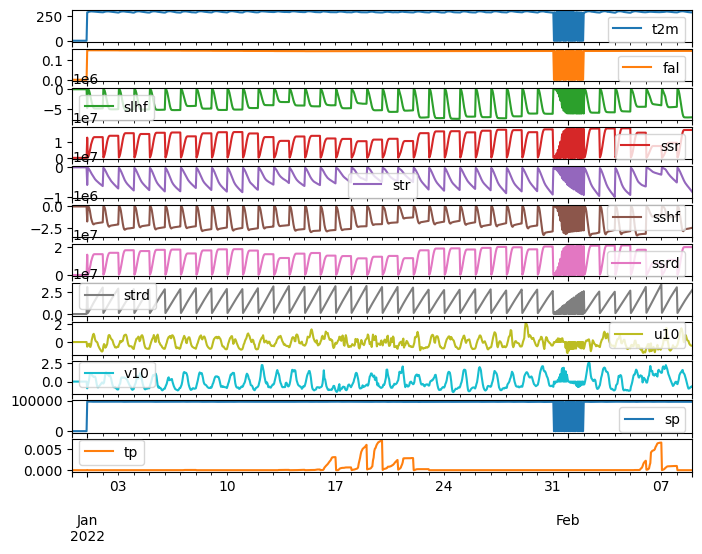

In [636]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

plot_features = df_with_all_times[all_cols]
plot_features.index = df_with_all_times.index
_ = plot_features.plot(subplots=True)

plot_features = df_with_all_times[all_cols][:960]
plot_features.index = complete_index[:960]
_ = plot_features.plot(subplots=True)

In [637]:
# Replace all NaN values in the DataFrame with 0
df_filled = df_with_all_times.fillna(0)
df_filled.shape

(33576, 12)

In [638]:
# Count NaNs in each column
print(df_filled.isna().sum())

t2m     0
fal     0
slhf    0
ssr     0
str     0
sshf    0
ssrd    0
strd    0
u10     0
v10     0
sp      0
tp      0
dtype: int64


In [639]:
df_filled.min()

t2m     0.000000e+00
fal     0.000000e+00
slhf   -1.389524e+07
ssr     0.000000e+00
str    -1.109148e+07
sshf   -8.090257e+06
ssrd    0.000000e+00
strd    0.000000e+00
u10    -2.419393e+00
v10    -3.001443e+00
sp      0.000000e+00
tp      0.000000e+00
dtype: float64

In [640]:
df_filled.max()

t2m     3.131051e+02
fal     1.766490e-01
slhf    7.579888e+03
ssr     2.277077e+07
str     0.000000e+00
sshf    1.392290e+05
ssrd    2.731737e+07
strd    3.700847e+07
u10     3.386670e+00
v10     3.727152e+00
sp      9.715571e+04
tp      6.097344e-02
dtype: float64

In [641]:
zero_mask = df_filled[all_cols].eq(0).all(axis=1)
zero_rows = df_filled.loc[zero_mask]
print(F"All zero row: {zero_rows.shape[0]}")

All zero row: 2664


# Start to fix missing row

In [741]:
zero_mask = df_filled[all_cols].eq(0).all(axis=1)
zero_rows = df_filled.loc[zero_mask]
print(F"All zero row: {zero_rows.shape[0]}")

All zero row: 2391


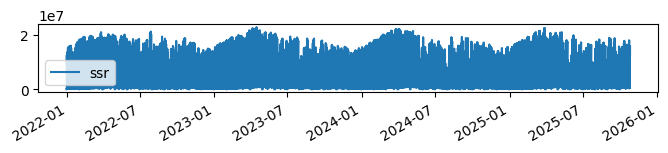

In [742]:
mpl.rcParams['figure.figsize'] = (8, 1)

if 'current_power' in df.columns:
    plot_cols = ['current_power']
elif 'sis' in df.columns:
    plot_cols = ['sis']
elif 'utci_mean' in df.columns:
    plot_cols = ['utci_mean']
elif 'r' in df.columns:
    plot_cols = ['r']
elif 'ssr' in df.columns:
    plot_cols = ['ssr']

plot_features = df_filled[plot_cols]
plot_features.index = df_filled.index
_ = plot_features.plot(subplots=True)

In [729]:
print(df_filled.index.year.unique())
print(df_filled.index.year.value_counts())

Index([2021, 2022, 2023, 2024, 2025], dtype='int32')
2022    8808
2023    8784
2024    8784
2025    7177
2021      23
Name: count, dtype: int64


In [730]:
## Create a copy of the dataframe
df_fixed = df_filled.copy()

# Variables from your code
year_to_fix = 2021
year_from = 2022

In [731]:
# Create date pattern columns BEFORE any filtering
df_fixed['date_pattern'] = df_fixed.index.strftime('%m-%d %H:%M')
df_fixed['date_pattern'].head(5)

2021-12-31 01:00:00    12-31 01:00
2021-12-31 02:00:00    12-31 02:00
2021-12-31 03:00:00    12-31 03:00
2021-12-31 04:00:00    12-31 04:00
2021-12-31 05:00:00    12-31 05:00
Name: date_pattern, dtype: object

In [732]:
# Find year rows with zeros (using your existing mask)
mask_from_year = df_fixed.index.year == year_from
year_rows = df_fixed.loc[mask_from_year]
print(F"There are {year_rows.shape[0]} in {year_from}")
year_rows.head(5)

There are 8808 in 2022


,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp,date_pattern
2022-01-01 00:00:00,290.025085,0.149562,-4.774743e+06,1.256176e+07,-5.922361e+06,-1.769391e+06,1.477109e+07,3.114296e+07,-0.513080,-0.924615,96539.637754,0.000055,01-01 00:00
2022-01-01 01:00:00,291.508870,0.149221,1.842960e+02,1.883910e+05,-1.703829e+05,2.655546e+03,2.214485e+05,1.223586e+06,-0.296069,-0.466538,96611.887479,0.000000,01-01 01:00
2022-01-01 02:00:00,294.567347,0.149221,-1.967692e+04,9.469646e+05,-3.679176e+05,-3.178817e+03,1.113083e+06,2.447816e+06,-0.252611,-0.145462,96647.004783,0.000000,01-01 02:00
2022-01-01 03:00:00,296.791950,0.149221,-3.868058e+05,2.303452e+06,-6.718119e+05,-1.536947e+05,2.707523e+06,3.696420e+06,-0.185559,0.352099,96682.313384,0.000000,01-01 03:00
2022-01-01 04:00:00,298.252622,0.149221,-1.026950e+06,4.095464e+06,-1.039364e+06,-4.565998e+05,4.813921e+06,4.974898e+06,-0.502260,0.980371,96641.248360,0.000000,01-01 04:00


In [733]:
# Find year rows with zeros (using your existing mask)
mask_to_year = df_fixed.index.year == year_to_fix
year_rows = df_fixed.loc[mask_to_year]
print(F"There are {year_rows.shape[0]} in {year_to_fix}")
year_rows.head(5)

There are 23 in 2021


,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp,date_pattern
2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 01:00
2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 02:00
2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 03:00
2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 04:00
2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 05:00


In [734]:
zero_mask = df_fixed[all_cols].eq(0).all(axis=1)
zero_rows = df_fixed.loc[zero_mask]
print(F"All zero row: {zero_rows.shape[0]}")

mask_zeros = mask_to_year & zero_mask
rows_to_fix = df_fixed[mask_zeros].copy()
print(F"There are [{rows_to_fix.shape[0]}] zero's rows of year {year_to_fix} to be fixed.")
rows_to_fix.head(5)

All zero row: 2391
There are [23] zero's rows of year 2021 to be fixed.


,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp,date_pattern
2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 01:00
2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 02:00
2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 03:00
2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 04:00
2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12-31 05:00


In [735]:
# Create lookup DataFrame from source year
source_data = df_fixed[mask_from_year]
lookup_df = source_data.drop_duplicates('date_pattern').set_index('date_pattern')[all_cols]
print(F"There are {lookup_df.shape[0]} rows from year {year_from}.")
lookup_df.head(5)

There are 8760 rows from year 2022.


,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
date_pattern,,,,,,,,,,,,
01-01 00:00,290.025085,0.149562,-4.774743e+06,1.256176e+07,-5.922361e+06,-1.769391e+06,1.477109e+07,3.114296e+07,-0.513080,-0.924615,96539.637754,0.000055
01-01 01:00,291.508870,0.149221,1.842960e+02,1.883910e+05,-1.703829e+05,2.655546e+03,2.214485e+05,1.223586e+06,-0.296069,-0.466538,96611.887479,0.000000
01-01 02:00,294.567347,0.149221,-1.967692e+04,9.469646e+05,-3.679176e+05,-3.178817e+03,1.113083e+06,2.447816e+06,-0.252611,-0.145462,96647.004783,0.000000
01-01 03:00,296.791950,0.149221,-3.868058e+05,2.303452e+06,-6.718119e+05,-1.536947e+05,2.707523e+06,3.696420e+06,-0.185559,0.352099,96682.313384,0.000000
01-01 04:00,298.252622,0.149221,-1.026950e+06,4.095464e+06,-1.039364e+06,-4.565998e+05,4.813921e+06,4.974898e+06,-0.502260,0.980371,96641.248360,0.000000


In [736]:
# Find which patterns harows_to_fixve matches and update them
matching_patterns = rows_to_fix['date_pattern'].isin(lookup_df.index)
matching_indices = rows_to_fix.loc[matching_patterns].index
print(f"Found {len(matching_indices)} rows with matching patterns in {year_from}")

Found 23 rows with matching patterns in 2022


In [737]:
# Update values for all matching rows at once
if len(matching_indices) > 0:
    for col in all_cols:
        # Get the replacement values from the lookup table
        replacement_values = rows_to_fix.loc[matching_indices, 'date_pattern'].map(lookup_df[col])
        
        # Update the values in df_fixed
        df_fixed.loc[matching_indices, col] = replacement_values

print(f"Fixed {len(matching_indices)} out of {len(rows_to_fix)} rows")

Fixed 23 out of 23 rows


In [738]:
# Clean up the temporary column - only if it exists
if 'date_pattern' in df_fixed.columns:
    df_fixed = df_fixed.drop('date_pattern', axis=1)
    print('Clean up [date_pattern] in df_fixed')
if 'date_pattern' in df.columns:
    df = df.drop('date_pattern', axis=1)
    print('Clean up [date_pattern] in df')

Clean up [date_pattern] in df_fixed


In [739]:
# Create a copy of the dataframe
df_filled = df_fixed.copy()
len(df_filled)

33576

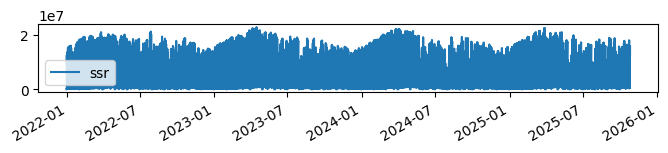

In [740]:
mpl.rcParams['figure.figsize'] = (8, 1)

plot_features = df_filled[plot_cols]
plot_features.index = df_filled.index
_ = plot_features.plot(subplots=True)

# End fix missing row

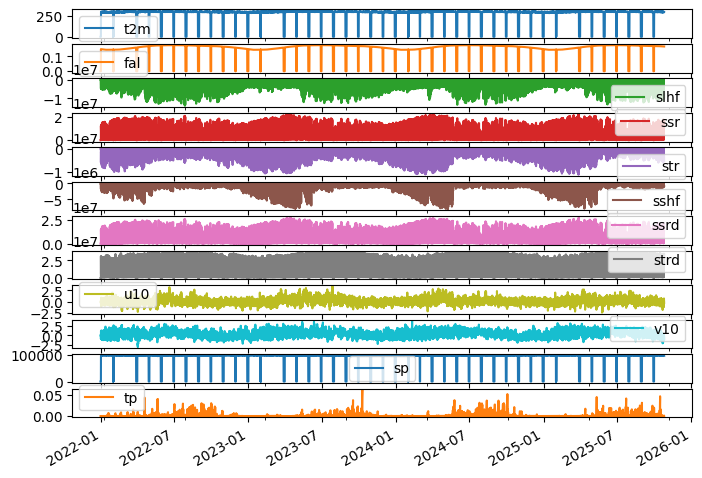

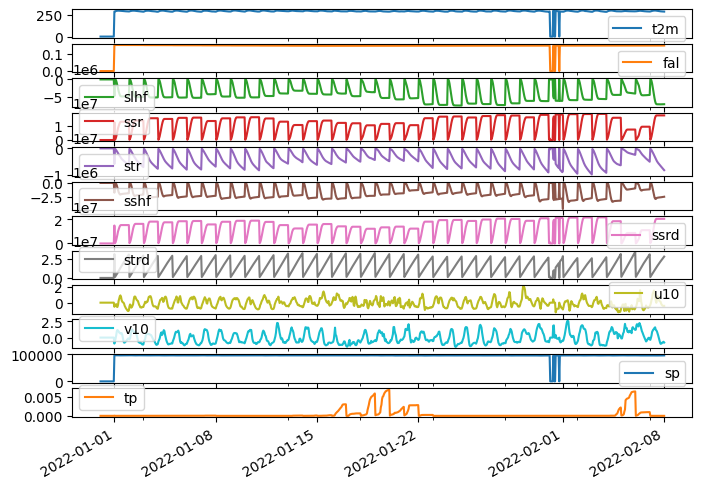

In [743]:
mpl.rcParams['figure.figsize'] = (8, 6)

plot_features = df_filled[all_cols]
plot_features.index = df_filled.index
_ = plot_features.plot(subplots=True)

plot_features = df_filled[all_cols][:960]
plot_features.index = df_filled.index[:960]
_ = plot_features.plot(subplots=True)

In [744]:
# Rename the index
df = df_filled.rename_axis('datetime')
df

,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
datetime,,,,,,,,,,,,
2021-12-31 01:00:00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2021-12-31 02:00:00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2021-12-31 03:00:00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2021-12-31 04:00:00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2021-12-31 05:00:00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-25 20:00:00,294.649222,0.167451,-7.264213e+06,1.214595e+07,-3.836861e+06,-963882.945891,1.458819e+07,2.811533e+07,0.029771,-1.062891,96091.953201,0.001001
2025-10-25 21:00:00,294.299961,0.167451,-7.258317e+06,1.214595e+07,-3.958078e+06,-958682.455550,1.458819e+07,2.948892e+07,-0.072683,-1.113487,96073.141025,0.001001
2025-10-25 22:00:00,294.010523,0.167451,-7.251573e+06,1.214595e+07,-4.093123e+06,-953146.010837,1.458819e+07,3.084515e+07,-0.113196,-1.129831,96071.828065,0.001001


In [745]:
len(df)

33576

In [746]:
filename = Path(csv_file).name
base = re.split(r'\.', filename, 1)[0]
print(base)

era5-land_timeseries


In [747]:
# Compressed CSV
df_filled.to_csv(base + '_filled.csv')